# Notebook 01: Experiments on Convolution Neural Networks with token embeddings

It is known that CNNs can perform well on some natural language processing tasks including text classification for their ability to capture long range relations. In the `PubMed`'s abstract dataset, these relations are, for example,


*  Abstracts are written in a similar pattern in the order of `OBJECTIVE`, `BACKGROUND`, `METHODS`, `RESULTS`, and `CONCLUSIONS`.
*  Sentences among each label category carry similarities across different abstracts.

So, here, I'd like to experiment on the CNNs to see how they perform on our text classification task. In this notebook, I'll use only token embedding methods. I will explore different embeddings in depth in the next notebook (notebook 02), where I will also build RNN models.

>[Notebook 01: Experiments on Convolution Neural Networks with token embeddings](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=9s65REin-QAZ)

>>[1.1 Load and check dependencies](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=LzhCNtFbJi0x)

>>>[1.1.1 Check GPU](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=6RbQpq0KKaWK)

>>>[1.1.2 Load and install libraries](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=Ba9WomL9KgyL)

>>>[1.1.3 Load and preprocess data](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=dl_esJYmJW_V)

>>[1.2 Token embeddings](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=00pjHnMeoDER)

>>>[1.2.1 Prepare for token embeddings](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=0b7xTDh--3u9)

>>>[1.2.2 Embedding No.1](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=bXLpWmOPsAoq)

>>>[1.2.3 Embedding No.2](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=KVCoLoE_sGJg)

>>[1.3 Experiments on CNN](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=MqwKpqyZLsxx)

>>>[1.3.1 Model_E1:](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=FV02ooo5L9GV)

>>>[1.3.2 Model_E2:](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=gUFABuZ9n9J3)

>>>>[1.3.2.1 CNN model](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=uTT2Tx_MWOBz)

>>>>[1.3.2.2 Dense model](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=0YfvXJs7WTXa)

>>>[1.3.3 Model comparison](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=Wwt4-0vPrVDF)

>>[1.4 The final CNN model](#updateTitle=true&folderId=1jOK8dPXjpbX30hsDi48mgZ6b3TXKUrvr&scrollTo=Uw-0dqkie0wb)



## 1.1 Load and check dependencies

### 1.1.1 Check GPU

In [42]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c73e873a-0f99-bf52-7bdc-28cea1f28405)


### 1.1.2 Load and install libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

`Tensorflow` has a known compatibility issue with `tensorflow_hub`. This issue can be resolved by using a previous version of tensorflow.

In [44]:
# revert back to a previous version of tensorflow
!pip -q install tensorflow==2.15.0 tensorflow-hub keras==2.15.0;

In [45]:
import tensorflow as tf

In [46]:
tf.version.VERSION

'2.15.0'

Next, import my utility functions from my github.

In [47]:
!wget https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py

from SkimLit_utils import *

--2024-12-26 06:33:45--  https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8052 (7.9K) [text/plain]
Saving to: ‘SkimLit_utils.py’

SkimLit_utils.py    100%[===================>]   7.86K  --.-KB/s    in 0s      

2024-12-26 06:33:45 (88.9 MB/s) - ‘SkimLit_utils.py’ saved [8052/8052]



### 1.1.3 Load and preprocess data

In [48]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [49]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

train_df, dev_df, test_df = SkimLit_preprocess_master(data_dir)
data_all = SkimLit_preprocess_OneHot_NN(train_df, dev_df, test_df)

train_sentences = data_all["train_text"]
dev_sentences = data_all["dev_text"]
test_sentences = data_all["test_text"]

train_labels_one_hot = data_all["train_label"]
dev_labels_one_hot = data_all["dev_label"]
test_labels_one_hot = data_all["test_label"]

Further, to make our later CNN models run faster, let us batch the data.

In [50]:
train_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                   train_labels_one_hot))
dev_data = tf.data.Dataset.from_tensor_slices((dev_sentences,
                                                 dev_labels_one_hot))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                  test_labels_one_hot))

train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
dev_data = dev_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## 1.2 Token embeddings

In this section, I will employ a customize token and a pretrained token embeddings. The CNN model in section 1.3 will use these two different token embeddings, and we will see how the model performs with the two embeddings.

### 1.2.1 Prepare for token embeddings

Before we construct the token embeddings, we need first to know:

1.   How many unique tokens (words), including special characters such as "." and "@", are there in our dataset?
2.   What is the distribution of the lengths of our sentences?

Let's answer these two questions first.

In [51]:
import multiprocessing

def word_set(sentences):
    """
    Process sentences to extract unique words.

    Argument:
        sentences (list): list of sentences

    Return:
        a set of unique words in the sentences
    """
    unique_words = set()
    for sentence in sentences:
        for word in sentence.split():
            unique_words.add(word)
    return unique_words

def unique_words(train_sentences, dev_sentences, test_sentences):
    """
    Find the number of unique words in the train, dev, and test sentences using multiprocessing.

    Argument:
        train_sentences (list): train sentences
        dev_sentences (list): development sentences
        test_sentences (list): test sentences

    Return:
        a dictionary containing the number of unique words for train, dev, and test data
    """
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        # process the sentences in parallel
        result = pool.map(word_set, [train_sentences, dev_sentences, test_sentences])

    unique_words_train, unique_words_dev, unique_words_test = result

    return {"train": len(unique_words_train),
            "dev": len(unique_words_dev),
            "test": len(unique_words_test)}

In [52]:
words_len = unique_words(train_sentences, dev_sentences, test_sentences)

print(words_len)

{'train': 69732, 'dev': 26276, 'test': 26069}


So, our training set contains 69732 unique words.

Let's see the distribution of the lengths of the training sentences.

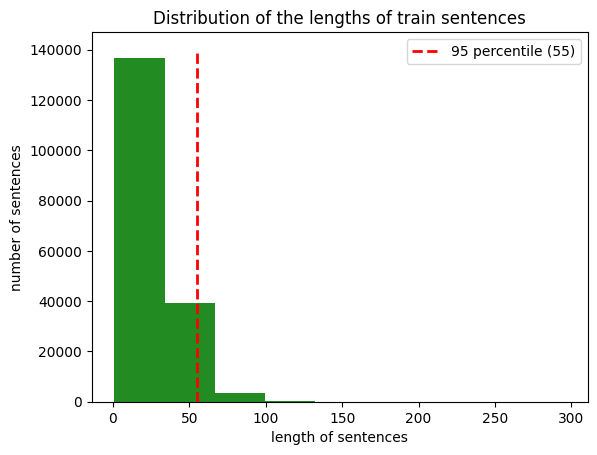

In [53]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

height_ = int(14e4)
Percentile95 = int(np.percentile(sent_lens, 95))

plt.hist(sent_lens, bins=9, color = "forestgreen")
plt.vlines(Percentile95,
           ymin = 0, ymax = height_,
           color = "red", linewidth = 2.0, linestyle = "--",
           label = f"95 percentile ({Percentile95})")
plt.xlabel("length of sentences")
plt.ylabel("number of sentences")
plt.title("Distribution of the lengths of train sentences")
plt.legend()
plt.show();

From the above histogram, we see that the 95-percentile for the lengths of training sentences is 55. Later in the tokenization process, we will transform all our sentences into the length of 55.

### 1.2.2 Embedding No.1

Similar to what we have done in **notebook00**, let me start with building a customized token vectorization using the `TextVectorization` method in `tensorflow`. For our training set has a total of 69732 unique words, let's use a maximum token of 60000 with a token vector of length 55 of our 95-percentile.

In [54]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 60000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=Percentile95)

text_vectorizer.adapt(train_sentences)

In [55]:
# Let's see an example
print(train_sentences[77], "\n")
print(text_vectorizer(train_sentences[77]))

mi delivered by providers and rds ( group @ ) resulted in statistically significant reductions in bmi percentile . 

tf.Tensor(
[1180  785   22 1672    3 7463   13  568    5  232   37  626    5  456
 3770    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(55,), dtype=int64)


In [56]:
train_text_vocab = text_vectorizer.get_vocabulary()
print(f"number of words: {len(train_text_vocab)}"),
print(f"most common words: {train_text_vocab[:10]}")
print(f"least common words: {train_text_vocab[-5:]}")

number of words: 60000
most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
least common words: ['demise', 'deming', 'demineralizationinduced', 'demineralisation', 'demethylation']


Next, we create a token embedding layer using the above text vectorization. This is our Embedding No.1, which will be used in section 1.3 with our CNN model.

In [57]:
token_embed = tf.keras.layers.Embedding(input_dim=len(train_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

### 1.2.3 Embedding No.2

Let us also explore a common pretrained embedding called the `universal sentence encoder`. This is our Embedding No.2.

In [58]:
import tensorflow_hub as hub
tf_hub_USC_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## 1.3 Experiments on CNN

For the purpose of this practice project, let me only consider a single CNN model and compare how it performs on the two different embedding methods discussed the last section.

### 1.3.1 Model_E1:

Let's see how a shallow (2 layers) CNN model performs on the classification task with our customized token embedding.

In [59]:
# model_CNN_E1
inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string)
text_vectors = text_vectorizer(inputs)
vec_embeds = token_embed(text_vectors)
x = tf.keras.layers.Conv1D(filters= 32, kernel_size=5, padding="same", activation="relu")(vec_embeds)
# using another Conv layer will overfit very quickly
#x = tf.keras.layers.Conv1D(filters = 16, kernel_size=3, padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x) # since we have 5 classes
model_CNN_E1 = tf.keras.Model(inputs, outputs, name = "model_CNN_E1")

model_CNN_E1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_CNN_E1.summary()

Model: "model_CNN_E1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           7680000   
 )                                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 32)            20512     
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                      

Let's fit the model with our training data.

In [60]:
model_CNN_E1_history = model_CNN_E1.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=5,
                              validation_data=dev_data,
                              validation_steps=len(dev_data))

Epoch 1/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.6270 - accuracy: 0.7710 - val_loss: 0.5508 - val_accuracy: 0.8025
Epoch 2/5
5627/5627 [==============================] - 39s 7ms/step - loss: 0.4629 - accuracy: 0.8382 - val_loss: 0.5391 - val_accuracy: 0.8079
Epoch 3/5
5627/5627 [==============================] - 39s 7ms/step - loss: 0.3886 - accuracy: 0.8667 - val_loss: 0.5623 - val_accuracy: 0.8070
Epoch 4/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.3298 - accuracy: 0.8895 - val_loss: 0.6093 - val_accuracy: 0.8014
Epoch 5/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.2807 - accuracy: 0.9081 - val_loss: 0.6702 - val_accuracy: 0.7955


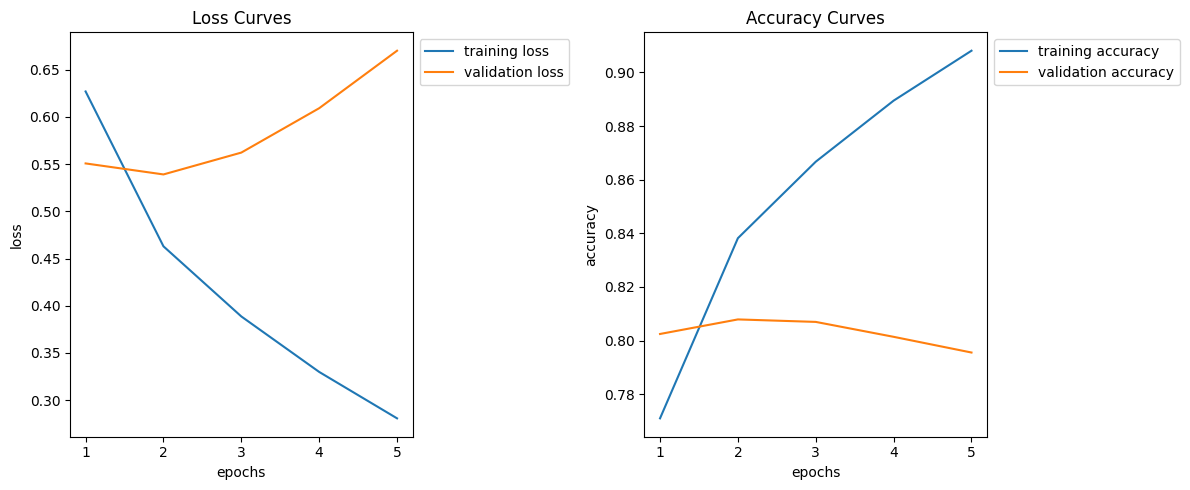

In [61]:
plot_loss_and_accuracy(model_CNN_E1_history)

From the above loss and accuracy plot, we see that our model is already overfitting from epoch 3. So, we should stop training at the end of epoch 2. Of course, we can attempt fine-tuning other hyperparameters such as learning rate to improve our model from epoch 2. However, for the purpose of this practice project, I'll stop here.

### 1.3.2 Model_E2:

Let's move on to build models using the `universal sentence encoder` embedding layer.

#### 1.3.2.1 CNN model

In [62]:
# Model_CNN_E2
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
USC_embeds = tf_hub_USC_embedding(inputs) # here we use the universal sentence encoder
x = tf.keras.layers.Reshape((USC_embeds.shape[-1], 1))(USC_embeds)
x = tf.keras.layers.Conv1D(filters = 32, kernel_size=5, padding="same", activation="relu")(x)
#x = tf.keras.layers.Conv1D(filters = 16, kernel_size=3, padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_CNN_E2 = tf.keras.Model(inputs,outputs,name = "model_CNN_E2")

model_CNN_E2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_CNN_E2.summary()

Model: "model_CNN_E2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 reshape_1 (Reshape)         (None, 512, 1)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 512, 32)           192       
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 5)                

In [63]:
model_CNN_E2_history = model_CNN_E2.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=5,
                              validation_data=dev_data,
                              validation_steps=len(dev_data))

Epoch 1/5
5627/5627 [==============================] - 101s 17ms/step - loss: 1.4706 - accuracy: 0.3305 - val_loss: 1.4657 - val_accuracy: 0.3639
Epoch 2/5
5627/5627 [==============================] - 88s 16ms/step - loss: 1.4677 - accuracy: 0.3354 - val_loss: 1.4644 - val_accuracy: 0.3633
Epoch 3/5
5627/5627 [==============================] - 100s 18ms/step - loss: 1.4659 - accuracy: 0.3429 - val_loss: 1.4619 - val_accuracy: 0.3612
Epoch 4/5
5627/5627 [==============================] - 88s 16ms/step - loss: 1.4629 - accuracy: 0.3508 - val_loss: 1.4582 - val_accuracy: 0.3642
Epoch 5/5
5627/5627 [==============================] - 87s 15ms/step - loss: 1.4589 - accuracy: 0.3573 - val_loss: 1.4538 - val_accuracy: 0.3689


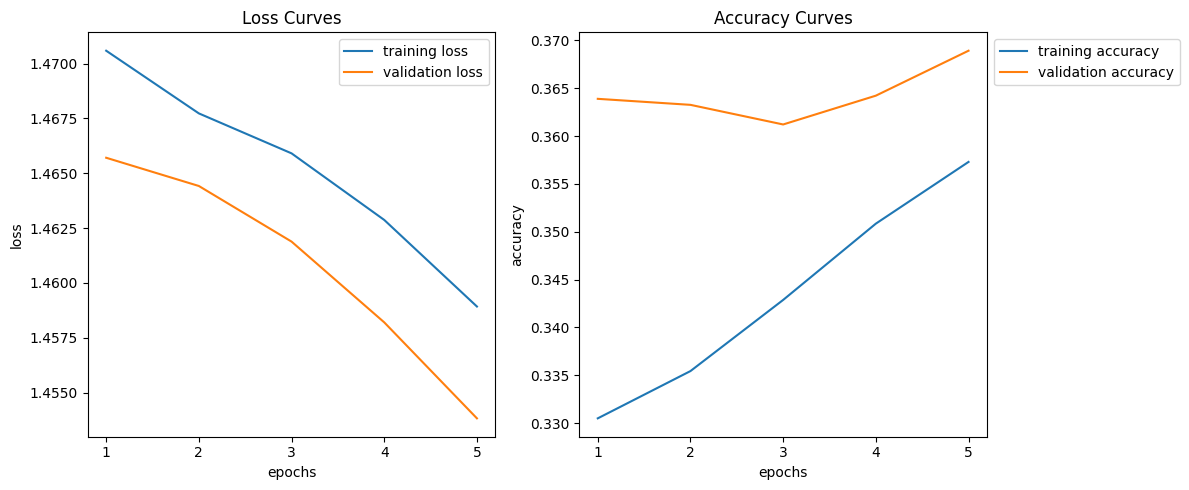

In [64]:
plot_loss_and_accuracy(model_CNN_E2_history)

With the `universal sentence encoder` token embedding layer, we see that our model trains very slowly but making steady progress towards better accuracy and lower loss for both the training and develpment sets. The reason for such slow progress compared to `Model_CNN_E1` is due to the fact that `universal sentence encoder` yields a larger token vector of dimension 512. In contrast, our customized token embedding has a dimension of only 55. In interest of time, I'll stop training this model at epoch 5.

#### 1.3.2.2 Dense model

Just out of curiousity, let's see how the `universal sentence encoder` performs on a simple dense model.

In [65]:
# Model_Dense_E2_2
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
USC_embeds = tf_hub_USC_embedding(inputs) # here we use the universal sentence encoder
x = tf.keras.layers.Dense(32)(USC_embeds)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_Dense_E2_2 = tf.keras.Model(inputs,outputs,name = "model_CNN_E2_2")

model_Dense_E2_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_Dense_E2_2.summary()

Model: "model_CNN_E2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 256814405 (979.67 MB)
Trainable params: 16581 (64.77 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [66]:
model_Dense_E2_2_history = model_Dense_E2_2.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=5,
                              validation_data=dev_data,
                              validation_steps=len(dev_data))

Epoch 1/5
5627/5627 [==============================] - 86s 15ms/step - loss: 0.7962 - accuracy: 0.6945 - val_loss: 0.7553 - val_accuracy: 0.7105
Epoch 2/5
5627/5627 [==============================] - 99s 18ms/step - loss: 0.7575 - accuracy: 0.7097 - val_loss: 0.7475 - val_accuracy: 0.7134
Epoch 3/5
5627/5627 [==============================] - 93s 17ms/step - loss: 0.7514 - accuracy: 0.7123 - val_loss: 0.7439 - val_accuracy: 0.7147
Epoch 4/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.7481 - accuracy: 0.7141 - val_loss: 0.7419 - val_accuracy: 0.7162
Epoch 5/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.7459 - accuracy: 0.7147 - val_loss: 0.7406 - val_accuracy: 0.7171


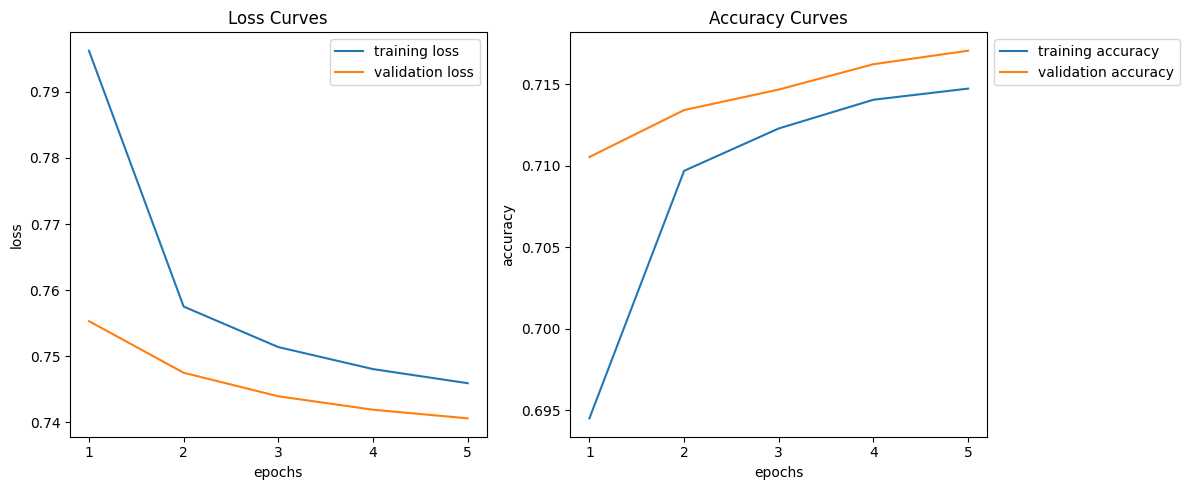

In [67]:
plot_loss_and_accuracy(model_Dense_E2_2_history)

So, our dense model gets a good result more quickly comparing to our CNN model for the `universal sentence encoder` token embedding.

### 1.3.3 Model comparison

Since the purpose of this notebook is to find the best CNN model, based on the accuracy we have here, I select `model_CNN_E1` as our current best CNN model.

## 1.4 The final CNN model

Let's see how our best CNN model performs on the development dataset.

In [68]:
def final_CNN_model():
  """
  Wrapper function for model_CNN_E1.
  Argument:
    None
  Return:
    model_CNN_E1 (tf.keras.Model): our CNN model
  """
  # model_CNN_E1
  inputs = tf.keras.layers.Input(shape=[1,], dtype=tf.string)
  text_vectors = text_vectorizer(inputs)
  vec_embeds = token_embed(text_vectors)
  x = tf.keras.layers.Conv1D(filters= 32, kernel_size=5, padding="same", activation="relu")(vec_embeds)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
  model_CNN_E1 = tf.keras.Model(inputs, outputs, name = "model_CNN_E1")

  model_CNN_E1.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
  return model_CNN_E1

model_CNN_final = final_CNN_model()
model_CNN_final.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=2,
                    validation_data=dev_data,
                    validation_steps=len(dev_data),
                    verbose=0)

model_CNN_final_pred_probs = model_CNN_final.predict(dev_data, verbose=0)

In [69]:
# Get the dev labels to compute evaluation scores
dev_labels_encoded = SkimLit_preprocess_EncodedLabels(train_df, dev_df, test_df)["dev_label"]

# Get the final predicted classes
model_CNN_final_preds = tf.argmax(model_CNN_final_pred_probs, axis=1).numpy()

In [70]:
model_CNN_final_results = perform_evaluations(y_true=dev_labels_encoded,
                                              y_pred=model_CNN_final_preds,
                                              model_name = "model_CNN_final")

model_CNN_final_results_df = pd.DataFrame(model_CNN_final_results)

model_CNN_final_results_df

,Metric,model_CNN_final
0,Accuracy,78.82
1,Precision,78.51
2,Recall,78.82
3,F1-score,78.50


Looks like the simple CNN model already beats the Random Forest (15) model on all scores!